# Max K-Vertex Cover

## Introduction

The Max K-Vertex Cover problem [[1]](#MVC) is a classical problem in graph theory and computer science, where we aim to find a set of vertices such that each edge of the graph is incident to at least one vertex in the set, and the size of the set does not exceed a given number $k$.



### Mathematical Formulation
The Max-k Vertex Cover problem can be formulated as an Integer Linear Program (ILP):

Minimize:
$\sum_{(i,j) \in E} (1 - x_i)(1 - x_j)$

Subject to:
$\sum_{i \in V} x_i = k$

and
$x_i \in \{0, 1\} \quad \forall i \in V$

Where:
- $x_i$ is a binary variable that equals 1 if node $i$ is in the cover and 0 otherwise
- $E$ is the set of edges in the graph
- $V$ is the set of vertices in the graph
- $k$ is the maximum number of vertices allowed in the cover




## Solving with the Classiq platform

We go through the steps of solving the problem with the Classiq platform, using QAOA algorithm [[2](#QAOA)]. The solution is based on defining a Pyomo model for the optimization problem we would like to solve.

In [1]:
import networkx as nx
import numpy as np
import pyomo.core as pyo
from IPython.display import Markdown, display
from matplotlib import pyplot as plt

## Building the Pyomo model from a graph input

We proceed by defining the Pyomo model that will be used on the Classiq platform, using the mathematical formulation defined above:

In [2]:
def mvc(graph: nx.Graph, k: int) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel()
    model.x = pyo.Var(graph.nodes, domain=pyo.Binary)
    model.amount_constraint = pyo.Constraint(expr=sum(model.x.values()) == k)

    def obj_expression(model):
        # number of edges not covered
        return sum((1 - model.x[i]) * (1 - model.x[j]) for i, j in graph.edges)

    model.cost = pyo.Objective(rule=obj_expression, sense=pyo.minimize)

    return model

The model contains:

- Index set declarations (model.Nodes, model.Arcs).
- Binary variable declaration for each node (model.x) indicating whether the variable is chosen for the set.
- Constraint rule – ensures that the set is of size k.
- Objective rule – counts the number of edges not covered; i.e., both related variables are zero.

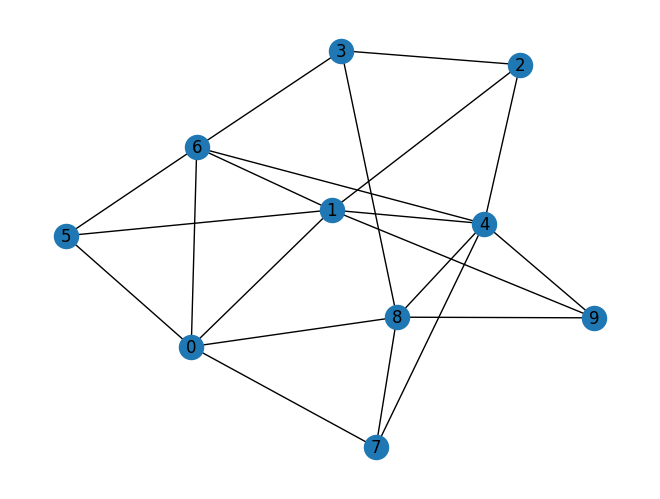

In [3]:
K = 5
num_nodes = 10
p_edge = 0.5
graph = nx.erdos_renyi_graph(n=num_nodes, p=p_edge, seed=13)

nx.draw_kamada_kawai(graph, with_labels=True)
mvc_model = mvc(graph, K)

In [4]:
mvc_model.pprint()

1 Var Declarations
    x : Size=10, Index={0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary
          6 :     0 :  None :     1 : False :  True : Binary
          7 :     0 :  None :     1 : False :  True : Binary
          8 :     0 :  None :     1 : False :  True : Binary
          9 :     0 :  None :     1 : False :  True : Binary

1 Objective Declarations
    cost : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : (1 - x[0])*(1 - x[1]) + (1 - x[0])*(1 - x[5]) + (1 - x[0])*(1 - x[6]) + (1 - x[0])*(1 - x[7]) + (1 - x[0])

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the `CombinatorialProblem` python class. Under the hood it tranlates the Pyomo model to a quantum model of the QAOA algorithm, with cost hamiltonian translated from the Pyomo model. We can choose the number of layers for the QAOA ansatz using the argument `num_layers`, and the `penalty_factor`, which will be the coefficient of the constraints term in the cost hamiltonian.

In [5]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=mvc_model, num_layers=3, penalty_factor=10)

qmod = combi.get_model()

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [6]:
qprog = combi.get_qprog()
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/38wAZjti7TSIt7NXGCJaFgelCqw


https://platform.classiq.io/circuit/38wAZjti7TSIt7NXGCJaFgelCqw?login=True&version=15

We also set the quantum backend we want to execute on:

In [7]:
from classiq.execution import *

execution_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator"),
)

We now solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [8]:
optimized_params = combi.optimize(execution_preferences, maxiter=90, quantile=0.7)

We can check the convergence of the run:

Text(0.5, 1.0, 'Cost convergence')

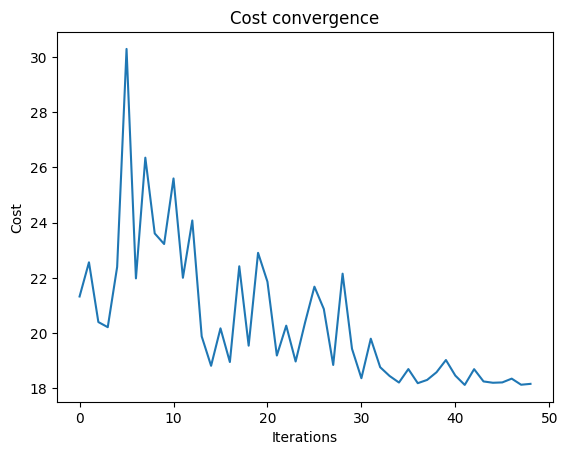

In [9]:
import matplotlib.pyplot as plt

plt.plot(combi.cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

## Optimization Results

We can also examine the statistics of the algorithm. In order to get samples with the optimized parameters, we call the `sample` method:

In [10]:
optimization_result = combi.sample(optimized_params)
optimization_result.sort_values(by="cost").head(5)

,solution,probability,cost
194,"{'x': [1, 1, 0, 1, 1, 0, 0, 0, 1, 0]}",0.001953,1
191,"{'x': [1, 1, 0, 1, 1, 0, 1, 0, 0, 0]}",0.001953,2
465,"{'x': [0, 1, 0, 0, 1, 0, 1, 1, 1, 0]}",0.000488,2
444,"{'x': [0, 1, 0, 1, 1, 1, 0, 0, 1, 0]}",0.000977,2
609,"{'x': [1, 1, 1, 0, 1, 0, 0, 0, 1, 0]}",0.000488,2


We will also want to compare the optimized results to uniformly sampled results:

In [11]:
uniform_result = combi.sample_uniform()

And compare the histograms:

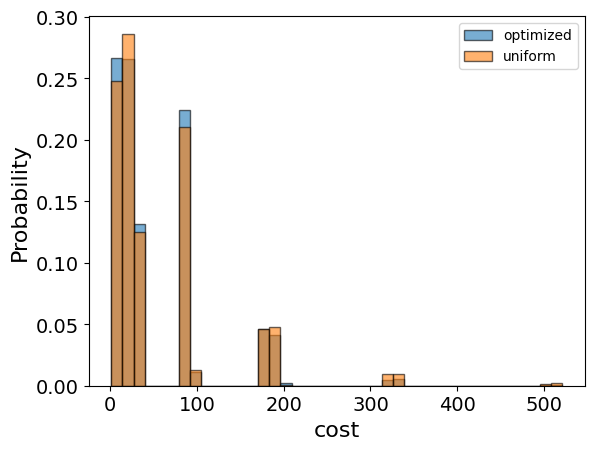

In [12]:
optimization_result["cost"].plot(
    kind="hist",
    bins=40,
    edgecolor="black",
    weights=optimization_result["probability"],
    alpha=0.6,
    label="optimized",
)
uniform_result["cost"].plot(
    kind="hist",
    bins=40,
    edgecolor="black",
    weights=uniform_result["probability"],
    alpha=0.6,
    label="uniform",
)
plt.legend()
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

Let us plot the solution:

In [13]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]["x"]
best_solution

[1, 1, 0, 1, 1, 0, 0, 0, 1, 0]

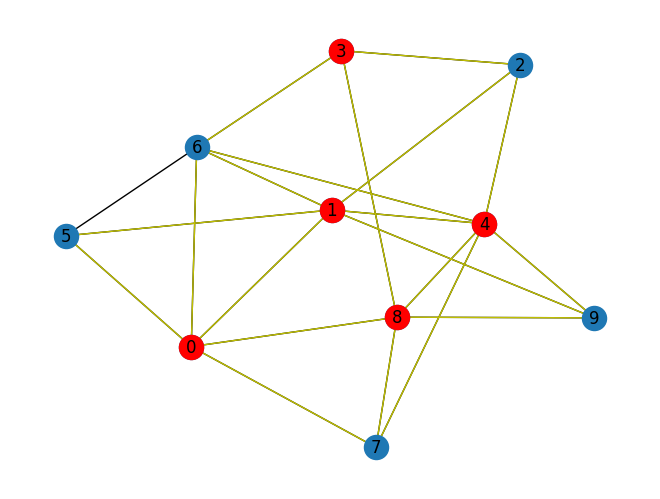

In [14]:
def draw_solution(graph: nx.Graph, solution: list):
    solution_nodes = [v for v in graph.nodes if solution[v]]
    solution_edges = [
        (u, v) for u, v in graph.edges if u in solution_nodes or v in solution_nodes
    ]
    nx.draw_kamada_kawai(graph, with_labels=True)
    nx.draw_kamada_kawai(
        graph,
        nodelist=solution_nodes,
        edgelist=solution_edges,
        node_color="r",
        edge_color="y",
    )


draw_solution(graph, best_solution)

## Comparison to a classical solver

Lastly, we can compare to the classical solution of the problem:

In [15]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(mvc_model)
classical_solution = [int(pyo.value(mvc_model.x[i])) for i in graph.nodes]

In [16]:
classical_solution

[1, 1, 0, 1, 1, 0, 0, 0, 1, 0]

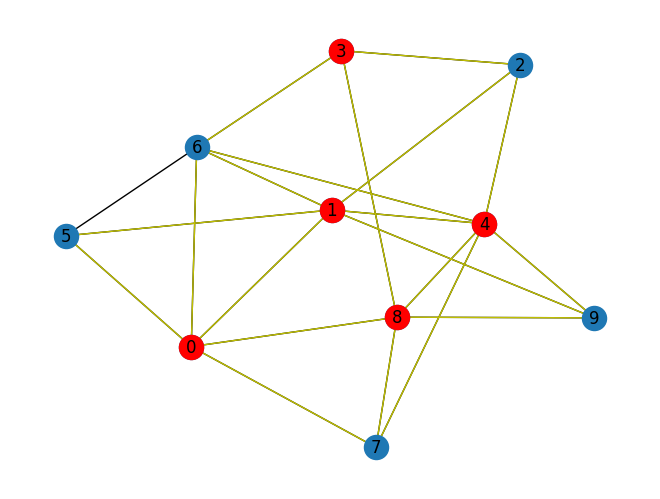

In [17]:
draw_solution(graph, classical_solution)


## References

<a id='MVC'>[1]</a>: [Max k-Vertex Cover.](https://arxiv.org/abs/1810.03792)

<a id='QAOA'>[2]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
